In [1]:
%matplotlib notebook
from QDP import qdp, atom
import os.path
import numpy as np
from scipy.stats import poisson
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_date = '2017_11_17'
exp_name = '2017_11_17_17_30_12_temperature'
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
cuts = [[16],[5]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
q.set_thresholds(cuts)

name 'fort_exp' is not defined


In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

In [4]:
retention = q.apply_thresholds()

In [5]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.985 +- 0.007
ivar:	4.44	retention:0.970 +- 0.010
ivar:	8.89	retention:0.940 +- 0.014
ivar:	13.33	retention:0.905 +- 0.017
ivar:	17.78	retention:0.820 +- 0.023
ivar:	22.22	retention:0.721 +- 0.027
ivar:	26.67	retention:0.741 +- 0.026
ivar:	31.11	retention:0.610 +- 0.029
ivar:	35.56	retention:0.572 +- 0.029
ivar:	40.00	retention:0.470 +- 0.030


In [6]:
q.save_experiment_data()

In [7]:
def fnode_release_recapture(t, T_uk):
    U_mk = 1.4
    wr_um = 2.5
    zr_um = 17.9  # calculated
    fr_khz = 48.0
    fa_khz = 4.7
    n=500000
    try:
        res = np.zeros(len(t))
        for i in xrange(len(t)):
            res[i] = atom.release_recapture(t[i], T_uk, U_mk, wr_um, zr_um, fr_khz, fa_khz, n=n)
        return res
    except Exception as e:
        print(e)
        return atom.release_recapture(t, T_uk, U_mk, wr_um, zr_um, fr_khz, fa_khz, n=n)

def residuals(T_uk, y, t, f0):
    res = y - f0*fnode_release_recapture(t, T_uk)
    #print "T_uk = {}, -> {}".format(T_uk, np.sum(np.power(res, 2)))
    return res

def ls_err(T_uk, y, t, f0):
    res = residuals(T_uk, y, t, f0)
    return np.sum(np.power(res, 2))

In [9]:
# do the fit by hand because curve_fit and least_squares dont seem to want to take large enough step sizes when searching
# this is a problem when the function is not very repeatable, like in a monte carlo
e=0
ls_data = np.array([[T, ls_err(T, retention['retention'][e], retention['ivar'][e], retention['retention'][e][0])] for T in np.linspace(58,70,11)])

<IPython.core.display.Javascript object>


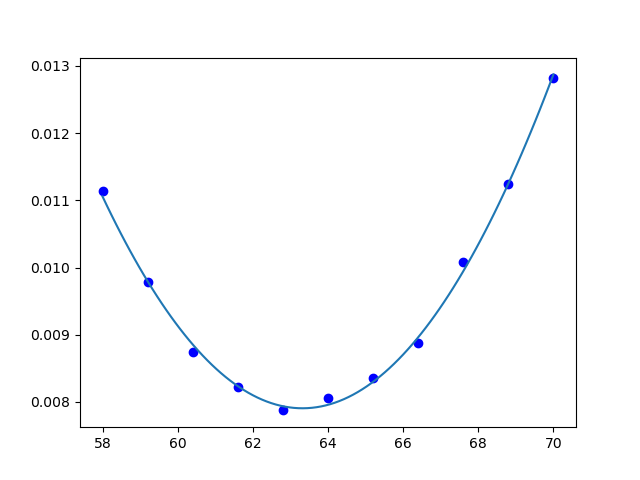

Optimization terminated successfully.
         Current function value: 0.007907
         Iterations: 16
         Function evaluations: 32


In [10]:
fig, ax = plt.subplots()
#print ls_data
z = np.polyfit(ls_data[:,0], ls_data[:,1], 2)
ax.plot(ls_data[:,0], ls_data[:,1], 'bo')
xs = np.linspace(58,70,100)
ax.plot(xs, np.poly1d(z)(xs))
T_opt = optimize.fmin(np.poly1d(z), 63)[0]

<IPython.core.display.Javascript object>


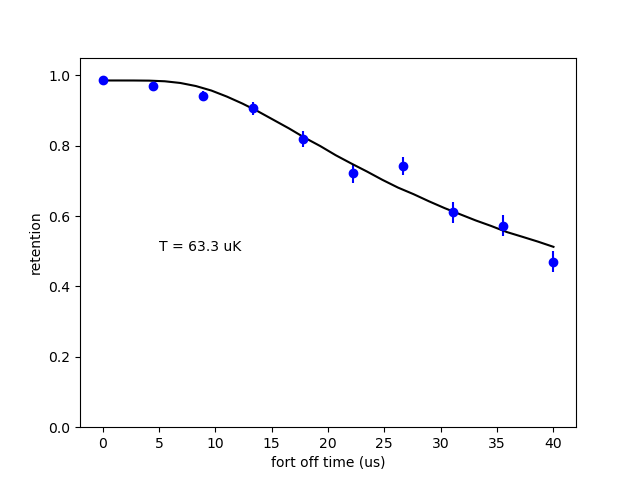

Text(0,0.5,u'retention')

In [11]:
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'bo'
    )
#     popt, pcov = optimize.curve_fit(
#         lambda t, T: retention['retention'][e][0]*fnode_release_recapture(t, T),
#         retention['ivar'][e],
#         retention['retention'][e],
#         sigma=retention['error'][e],
#         p0=[50]
#     )
#     print(popt)
#     T_opt = popt[0]
#    x, flag = optimize.least_squares(residuals, np.array([50.0]), args=(retention['retention'][e], retention['ivar'][e]))
#     residuals(50, retention['retention'][e], retention['ivar'][e])
    xs = np.linspace(min(retention['ivar'][e]), max(retention['ivar'][e]), 30)
    ax.plot(xs, fnode_release_recapture(xs, T_opt)*retention['retention'][e][0], 'k-')
    ax.text(5, 0.5, "T = {:.1f} uK".format(T_opt))
ax.set_ylim(0, 1.05)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')

In [71]:
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'temperature_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)